In [38]:
%load_ext autoreload
%autoreload 2
import espaloma as esp
import torch
import pinot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
g = esp.Graph('C')

forcefield = esp.graphs.legacy_force_field.LegacyForceField(
    "smirnoff99Frosst"
)

forcefield.parametrize(g)

from espaloma.data.md import MoleculeVacuumSimulation
simulation = MoleculeVacuumSimulation(
    n_samples=100,
    n_steps_per_sample=10,
)
simulation.run(g)

/Users/wangy1/anaconda3/envs/pinot/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [32]:
representation = esp.nn.baselines.FreeParameterBaseline(g_ref=g.heterograph)

# epsilon = 0.1

for term in ['n2', 'n3']:
    for param in ['k', 'eq']:
        setattr(
            representation, '%s_%s' % (term, param),
            torch.nn.Parameter(
                torch.distributions.normal.Normal(
                    loc=torch.zeros_like(g.nodes[term].data[param + '_ref'].data),
                    scale=torch.ones_like(g.nodes[term].data[param + '_ref'].data),
            ).sample().exp()
        ))
        
net = torch.nn.Sequential(
        representation, 
        esp.mm.geometry.GeometryInGraph(),
        esp.mm.energy.EnergyInGraph(), # predicted energy -> u
        esp.mm.energy.EnergyInGraph(suffix='_ref') # reference energy -> u_ref,
)

# optimizer = pinot.BBB(
#     torch.optim.Adam(
#         net.parameters(),
#         0.01,
# ),


optimizer = torch.optim.LBFGS(
    net.parameters(),
    0.1,
    line_search_fn='strong_wolfe',
)

In [33]:
net(g.heterograph)

Graph(num_nodes={'n1': 5, 'n2': 8, 'n3': 12, 'n4': 0, 'nonbonded': 0, 'onefour': 0, 'g': 1},
      num_edges={('n1', 'n1_neighbors_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n2', 'n2'): 8, ('n2', 'n2_has_0_n1', 'n1'): 8, ('n1', 'n1_as_1_in_n2', 'n2'): 8, ('n2', 'n2_has_1_n1', 'n1'): 8, ('n1', 'n1_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n1', 'n1'): 12, ('n1', 'n1_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n1', 'n1'): 12, ('n1', 'n1_as_2_in_n3', 'n3'): 12, ('n3', 'n3_has_2_n1', 'n1'): 12, ('n1', 'n1_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n1', 'n1'): 0, ('n1', 'n1_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n1', 'n1'): 0, ('n1', 'n1_as_2_in_n4', 'n4'): 0, ('n4', 'n4_has_2_n1', 'n1'): 0, ('n1', 'n1_as_3_in_n4', 'n4'): 0, ('n4', 'n4_has_3_n1', 'n1'): 0, ('n2', 'n2_as_0_in_n3', 'n3'): 12, ('n3', 'n3_has_0_n2', 'n2'): 12, ('n2', 'n2_as_1_in_n3', 'n3'): 12, ('n3', 'n3_has_1_n2', 'n2'): 12, ('n2', 'n2_as_0_in_n4', 'n4'): 0, ('n4', 'n4_has_0_n2', 'n2'): 0, ('n2', 'n2_as_1_in_n4', 'n4'): 0, ('n4', 'n4_has_1_n

In [34]:
states = []
losses = []

In [35]:
def l():
    net(g.heterograph)

    loss = torch.nn.MSELoss()(
        g.nodes['g'].data['u_ref'].log(),
        g.nodes['g'].data['u'].log(),
    )

    loss = loss.sum()

    losses.append(loss.detach().numpy())

    # loss.backward()

    print(loss)
    return loss

l()
# optimizer.step(l)

tensor(1.9018, grad_fn=<SumBackward0>)


tensor(1.9018, grad_fn=<SumBackward0>)

In [36]:
g.nodes['n3'].data['k']

Parameter containing:
tensor([[1.3585],
        [0.2003],
        [0.6962],
        [0.4828],
        [9.4376],
        [1.9960],
        [0.5068],
        [0.3768],
        [3.9533],
        [1.2907],
        [6.4080],
        [1.1651]], requires_grad=True)

In [37]:
for _ in range(5000):
    optimizer.zero_grad()
    
    def l():
        net(g.heterograph)
        
        loss = torch.nn.MSELoss()(
            g.nodes['n2'].data['u_ref'],
            g.nodes['n2'].data['u'],
        )

        loss = loss.sum()
        
        losses.append(loss.detach().numpy())
        
        loss.backward()
        
        print(loss)
        return loss
    
    optimizer.step(l)
    
    states.append(
        {
            '%s_%s' % (term, param): getattr(
                net[0],
                '%s_%s' % (term, param)
            ).detach().clone().numpy()
            for term in ['n3'] for param in ['k', 'eq']
        }
    )

tensor(4.1564, grad_fn=<SumBackward0>)
tensor(4.1564, grad_fn=<SumBackward0>)
tensor(4.1564, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1562, grad_fn=<SumBackward0>)
tensor(4.1561, grad_fn=<SumBackward0>)
tensor(4.1561, grad_fn=<SumBackward0>)
tensor(4.1561, grad_fn=<SumBackward0>)
tensor(4.1561, grad_fn=<SumBackward0>)
tensor(4.1561, grad_fn=<SumBackward0>)
tensor(4.1561, grad_fn=<SumBackward0>)
tensor(4.1561, grad_fn=<SumBackward0>)
tensor(4.1561, grad_fn=<S

tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<S

tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<S

tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<SumBackward0>)
tensor(4.1560, grad_fn=<S

KeyboardInterrupt: 

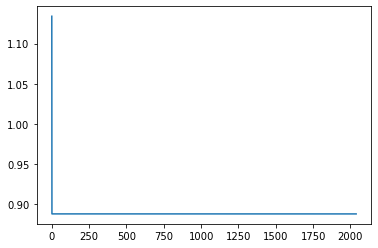

In [28]:
from matplotlib import pyplot as plt
plt.plot(losses)

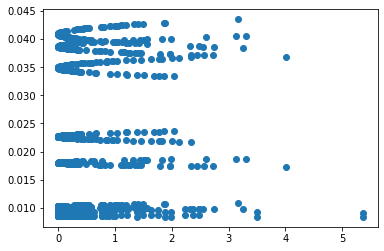

In [29]:
plt.scatter(
    g.nodes['n2'].data['u_ref'].flatten().detach(),
    g.nodes['n2'].data['u'].flatten().detach(),
)